# Task 1.1: Prediction with RNN

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.load_data import get_data, load_daily_consumptions
from src.train import FederatedLearning
from src.config import Config, load_train_config

import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import torch
torch.manual_seed(101)

## Specify parameters

### Manually set config

In [3]:
kwargs = {
    # Main mode
    "mode": "prediction",

    # Model config
    "model": "RNN",  # LSTM or RNN
    "hidden_dim": 32,
    "num_layers": 1,
    "dropout": 0.0,

    # Training config
    "epochs": 1000,
    "lr": 3e-4,
    "batch_size": 128
}

config = Config(**kwargs)

In [4]:
# Save config
#config.save("default_pred_rnn")

### Load saved config

In [5]:
config = load_train_config("config_default_pred_rnn")
print(config)

Config loaded from: config/config_default_pred_rnn.json
CONFIG:
  mode: prediction
  test_size: 0.2
  val_size: 0.1
  shuffle: True
  seed: 42
  model: RNN
  input_dim: 1
  hidden_dim: 32
  output_dim: 1
  num_layers: 1
  dropout: 0.0
  epochs: 1000
  lr: 0.0003
  batch_size: 128
  eval_steps: 50


## Run FL training

In [67]:
splits, x, y, (tr_ix, val_ix, te_ix) = get_data(config, return_index=True)
x_train, x_val, x_test, y_train, y_val, y_test = splits
daily_cons = load_daily_consumptions()

In [23]:
fl = FederatedLearning(config)
fl.train(x_train, y_train, x_val, y_val)

TRAIN:
  Epoch: 1,  train loss: 118.97381, val loss: 660.39728
  Epoch: 50,  train loss: 102.16174, val loss: 527.27521
  Epoch: 100,  train loss: 28.44395, val loss: 59.80009
  Epoch: 150,  train loss: 18.29527, val loss: 54.39159
  Epoch: 200,  train loss: 18.64314, val loss: 52.50261
  Epoch: 250,  train loss: 20.63365, val loss: 50.37776
  Epoch: 300,  train loss: 15.43227, val loss: 49.37632
  Epoch: 350,  train loss: 16.25660, val loss: 48.50850
  Epoch: 400,  train loss: 14.04986, val loss: 47.98643
  Epoch: 450,  train loss: 13.12542, val loss: 47.56351
  Epoch: 500,  train loss: 13.86621, val loss: 47.23678
  Epoch: 550,  train loss: 17.13761, val loss: 46.97352
  Epoch: 600,  train loss: 24.07419, val loss: 46.87949
  Epoch: 650,  train loss: 15.65261, val loss: 46.76908
  Epoch: 700,  train loss: 15.60651, val loss: 46.73943
  Epoch: 750,  train loss: 16.19267, val loss: 46.73561
  Epoch: 800,  train loss: 23.17226, val loss: 46.75103
  Epoch: 850,  train loss: 21.26261, val

### Analysis

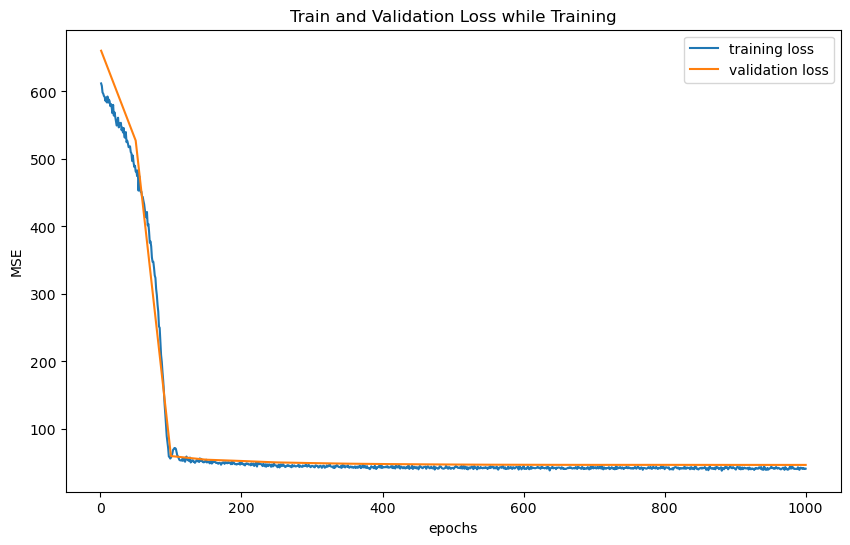

In [24]:
fl.plot_training_loss()

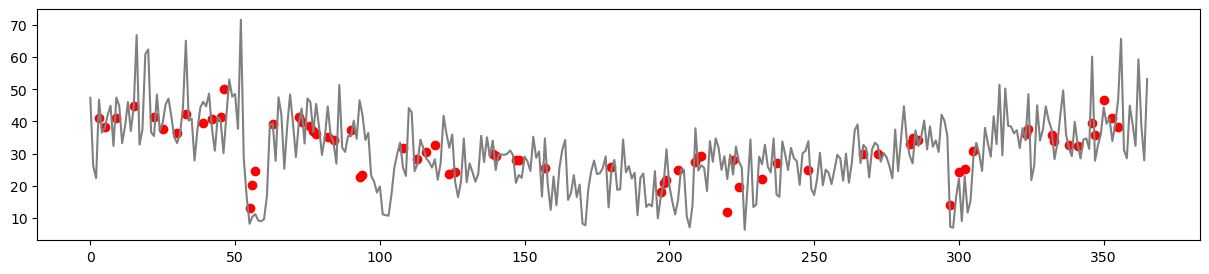

In [76]:
ix = te_ix.sort()[0]
fl.model.eval()
with torch.no_grad():
  y_pred = fl.model(x[0, ix]).reshape(-1)
plt.figure(figsize=(15, 3))
plt.plot(daily_cons[0], c="gray")
plt.scatter(ix, y_pred, c="r");

In [54]:

#x[:, ix].reshape(-1).shape, y[:, ix].reshape(-1).shape
l = []
for i in ix:
  if not l or (l[-1][-1] + 1) != i:
    l.append([i.item()])
  else:
    l[-1].append(i.item())
len(l), l, torch.mean(torch.tensor([len(x) for x in l]).float())

(53,
 [[3],
  [5],
  [9],
  [15],
  [22],
  [25],
  [30],
  [33],
  [39],
  [42],
  [45, 46],
  [55, 56, 57],
  [63],
  [72, 73],
  [76, 77, 78],
  [82],
  [84],
  [90],
  [93, 94],
  [108],
  [113],
  [116],
  [119],
  [124],
  [126],
  [139, 140],
  [147, 148],
  [157],
  [180],
  [197, 198, 199],
  [203],
  [209, 210, 211],
  [220],
  [222],
  [224],
  [232],
  [237],
  [248],
  [267],
  [272],
  [283, 284, 285, 286],
  [297],
  [300],
  [302],
  [305],
  [323, 324],
  [332, 333],
  [338],
  [341],
  [346, 347],
  [350],
  [353],
  [355]],
 tensor(1.3585))

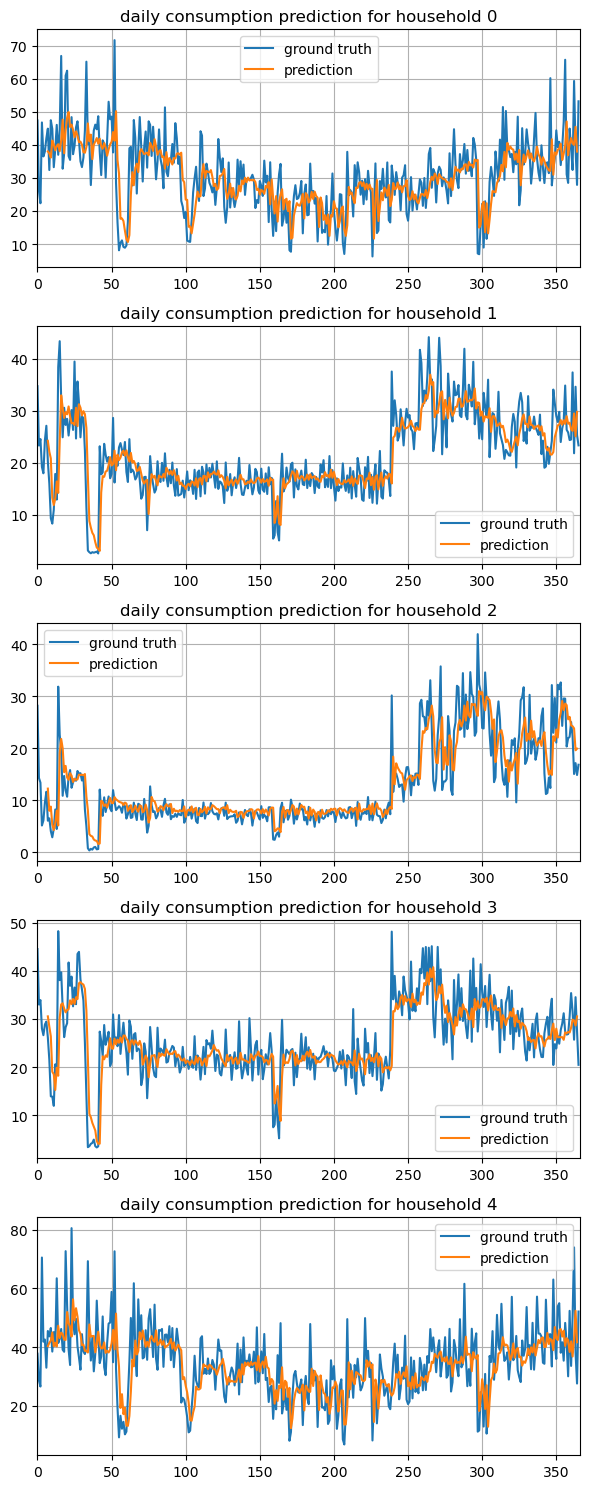

In [14]:
fl.plot_daily_consumption_prediction()

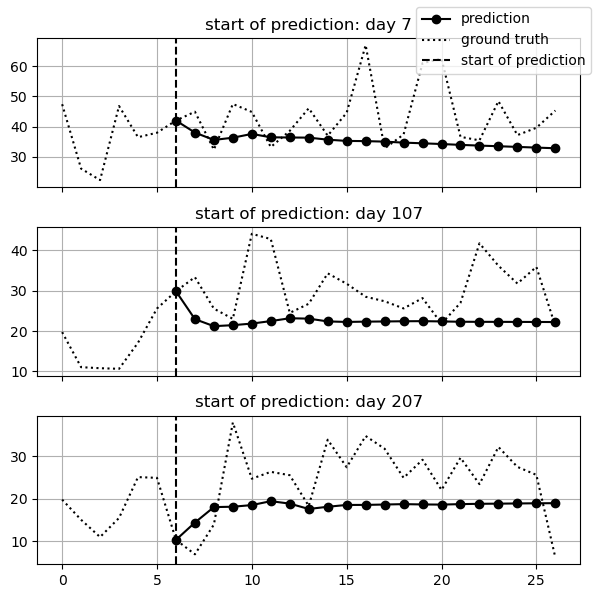

In [11]:
fl.plot_recursive_time_evolution()

METRICS:
  Mean model Test MSE:  173.2198944091797
  Mean model Test RMSE: 13.16130256652832
  Model Test MSE:       48.225772857666016
  Model Test RMSE:      6.9444780349731445


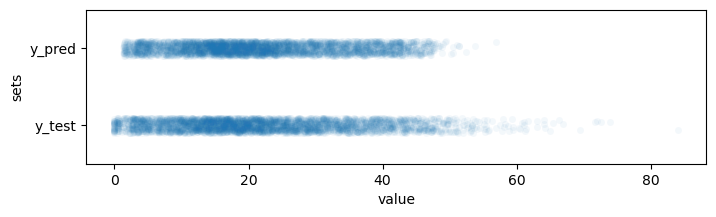

In [12]:
y_pred = fl.evaluation_metrics(x_test, y_test)
plt.figure(figsize=(8,2))
sns.stripplot(
  pd.DataFrame({"y_pred": y_pred.numpy()[:,0], "y_test": y_test.numpy().reshape(-1)}).melt(var_name="sets"),
  x="value", y="sets", alpha=.05,
);

## Run training with aggregated data

In [12]:
x_train, x_val, x_test, y_train, y_val, y_test = get_data(config)

# Stack data to aggregate all households to one
x_train, x_val, x_test = [arr.reshape(1, arr.shape[0] * arr.shape[1], arr.shape[2]) for arr in [x_train, x_val, x_test]]
y_train, y_val, y_test = [arr.reshape(1, arr.shape[0] * arr.shape[1]) for arr in [y_train, y_val, y_test]]

In [13]:
fl_agg = FederatedLearning(config)
fl_agg.train(x_train, y_train, x_val, y_val)

TRAIN:
  Epoch: 1,  train loss: 620.32507, val loss: 660.39740
  Epoch: 50,  train loss: 492.45029, val loss: 531.19318
  Epoch: 100,  train loss: 110.71841, val loss: 122.98560
  Epoch: 150,  train loss: 48.78674, val loss: 52.66908
  Epoch: 200,  train loss: 51.82477, val loss: 51.41979
  Epoch: 250,  train loss: 39.67406, val loss: 50.50826
  Epoch: 300,  train loss: 62.38641, val loss: 50.07088
  Epoch: 350,  train loss: 52.77702, val loss: 49.52326
  Epoch: 400,  train loss: 37.05338, val loss: 48.84118
  Epoch: 450,  train loss: 39.52591, val loss: 49.20178
  Epoch: 500,  train loss: 53.69596, val loss: 48.29996
  Epoch: 550,  train loss: 41.00536, val loss: 48.04651
  Epoch: 600,  train loss: 45.85776, val loss: 47.97482
  Epoch: 650,  train loss: 26.45318, val loss: 47.76035
  Epoch: 700,  train loss: 38.21388, val loss: 47.68870
  Epoch: 750,  train loss: 35.96727, val loss: 47.46124
  Epoch: 800,  train loss: 33.03128, val loss: 47.31756
  Epoch: 850,  train loss: 37.12823, v

### Analysis

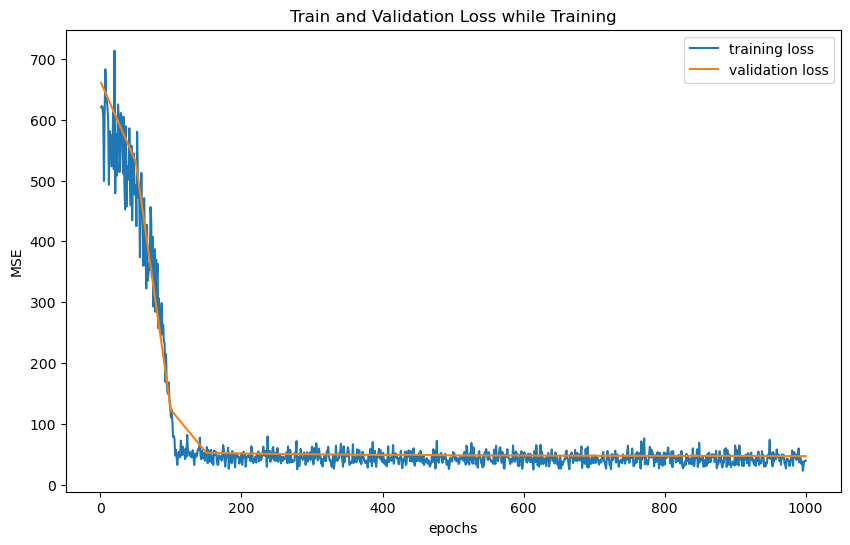

In [14]:
fl_agg.plot_training_loss()

In [15]:
y_pred = fl_agg.evaluation_metrics(x_test, y_test)

METRICS:
  Mean model Test MSE:  173.2198944091797
  Mean model Test RMSE: 13.16130256652832
  Model Test MSE:       49.52976989746094
  Model Test RMSE:      7.037738800048828
